In [16]:
from visual_behavior import utilities as vbu
import visual_behavior.plotting as vbp
from visual_behavior.utilities import EyeTrackingData
from visual_behavior import database as db
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import seaborn as sns
import matplotlib.patches as patches

from scipy import stats

from multiprocessing import Pool

from dro.modules import eye_tracking as et
from dro.modules import plotting as plot_utils

from scipy.signal import spectrogram
import pywt

In [2]:
%matplotlib notebook
%widescreen

In [3]:
osid = 913564409
ed = et.open_eye_data(osid)
bd = et.open_behavior_data(osid)

on osid = 913564409
on osid = 913564409


<IPython.core.display.Javascript object>


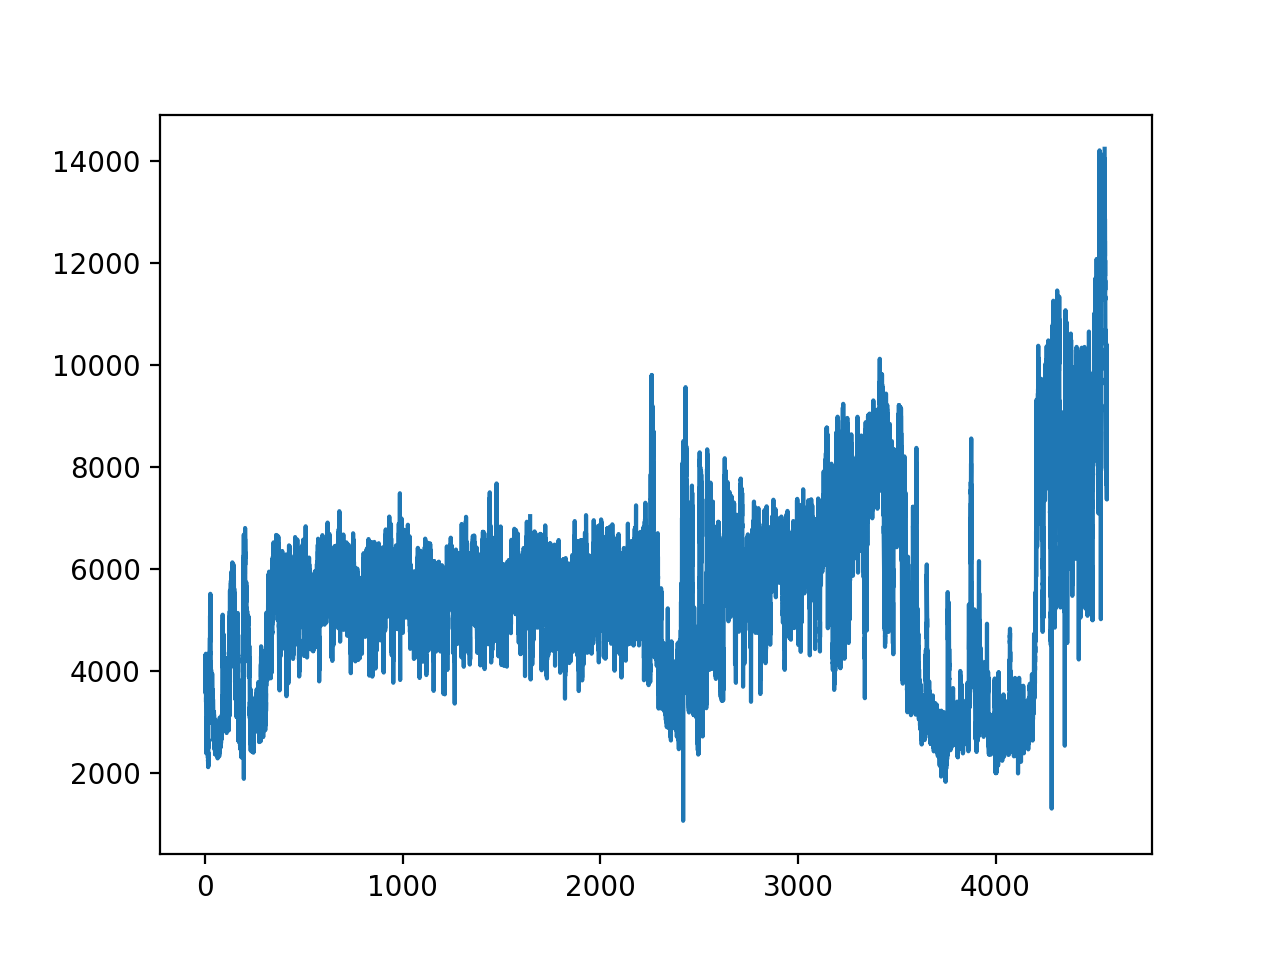

In [8]:
fig,ax=plt.subplots()
ax.plot(
    ed.ellipse_fits['pupil']['time'],
    ed.ellipse_fits['pupil']['blink_corrected_area']
)

## here's an example from stack overflow (https://stackoverflow.com/questions/54909178/spectrogram-vs-scaleogram-for-time-varying-frequency) showing how to apply sliding window FFT and wavelet transform. I don't understand how to interpret the wavelet transform (and nor does the person who posted to stack overflow: it's an unanswered question).

<IPython.core.display.Javascript object>


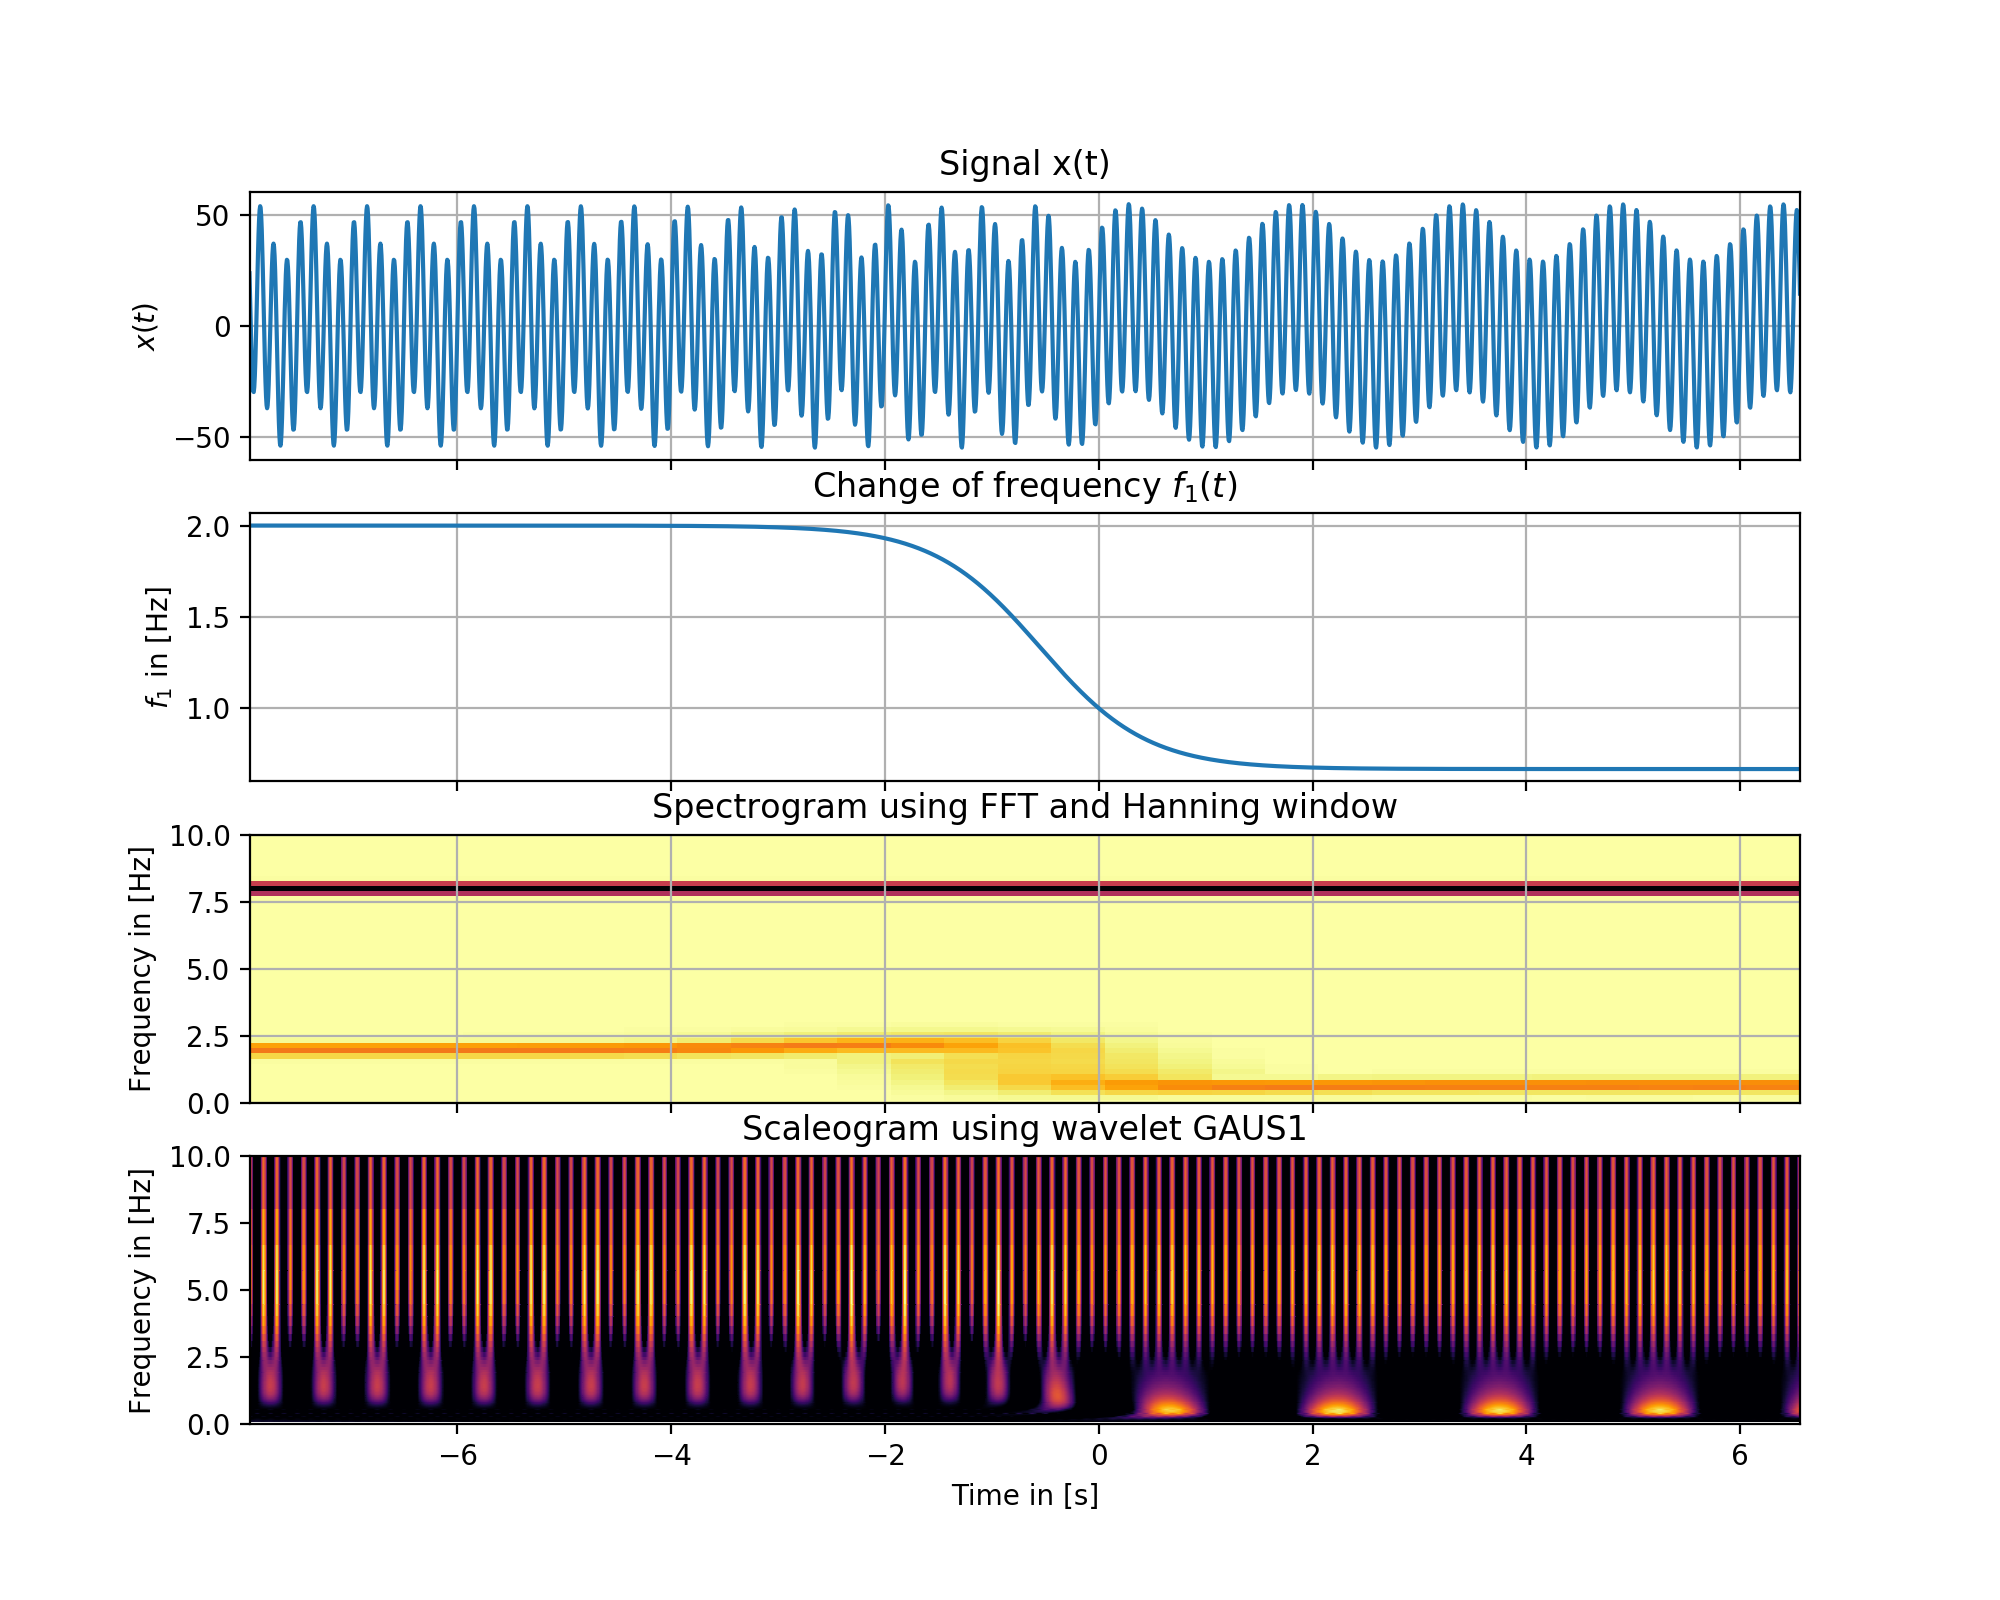

In [25]:
f_s = 200              # Sampling rate = number of measurements per second in [Hz]
t   = np.arange(-10,10, 1 / f_s) # Time between [-10s,10s].
T1  = np.tanh(t)/2  + 1.0 # Period in [s]
T2  = 0.125               # Period in [s]
f1  = 1 / T1              # Frequency in [Hz]
f2  = 1 / T2              # Frequency in [Hz] 

N = len(t)
x = 13 * np.sin(2 * np.pi * f1 * t) + 42 * np.sin(2 * np.pi * f2 * t)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))

# Signal
ax1.plot(t, x)
ax1.grid(True)
ax1.set_ylabel("$x(t)$")
ax1.set_title("Signal x(t)")

# Frequency change
ax2.plot(t, f1)
ax2.grid(True)
ax2.set_ylabel("$f_1$ in [Hz]")
ax2.set_title("Change of frequency $f_1(t)$")

# Moving fourier transform, i.e. spectrogram
delta_t = 4 # window length in [s]
Nw = np.int(2**np.round(np.log2(delta_t * f_s))) # Number of datapoints within window
f, t_, Sxx = spectrogram(x, f_s, window='hanning', nperseg=Nw, noverlap = Nw - 100, detrend=False, scaling='spectrum')
delta_f  =  f[1] - f[0]
delta_t_ = t_[1] - t_[0]
t2  = t_ + t[0] - delta_t_

im = ax3.pcolormesh(t2, f - delta_f/2, np.sqrt(2*Sxx), cmap = "inferno_r")#, alpha = 0.5)
ax3.grid(True)
ax3.set_ylabel("Frequency in [Hz]")
ax3.set_ylim(0, 10)
ax3.set_xlim(np.min(t2),np.max(t2))
ax3.set_title("Spectrogram using FFT and Hanning window")

# Wavelet transform, i.e. scaleogram
cwtmatr, freqs = pywt.cwt(x, np.arange(1, 512), "gaus1", sampling_period = 1 / f_s)
im2 = ax4.pcolormesh(t, freqs, cwtmatr, vmin=0, cmap = "inferno" )  
ax4.set_ylim(0,10)
ax4.set_ylabel("Frequency in [Hz]")
ax4.set_xlabel("Time in [s]")
ax4.set_title("Scaleogram using wavelet GAUS1")

# plt.savefig("./fourplot.pdf")

plt.show()

## I'll use the same methods to apply a sliding window FFT to the pupil data

<IPython.core.display.Javascript object>


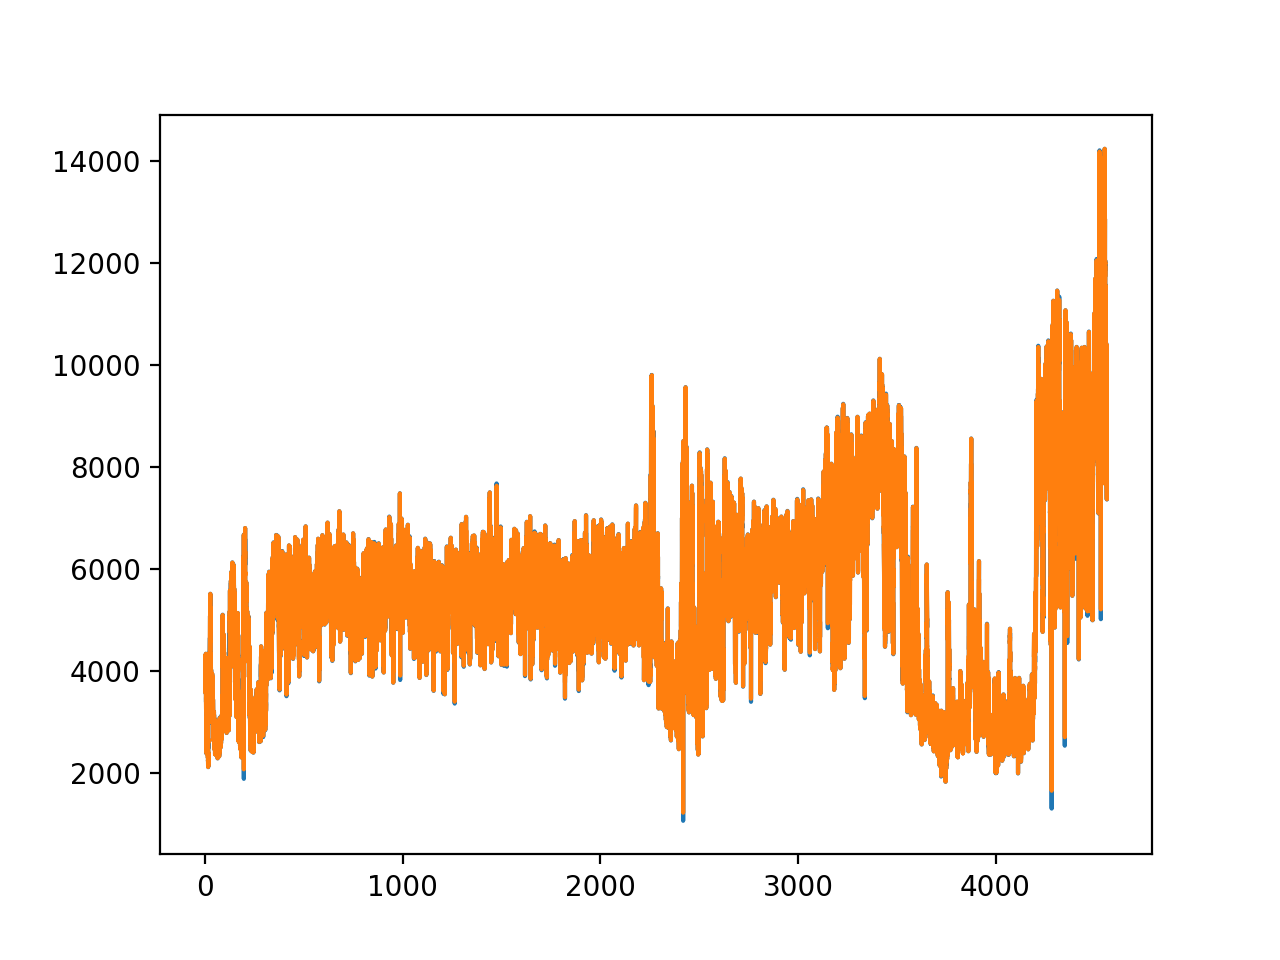

In [97]:
df = ed.ellipse_fits['pupil'].set_index('time')
t = df.index.values
y = df['blink_corrected_area'].fillna(method='ffill').values

new_t = np.arange(t.min(),t.max(),0.005)
y_interp = np.interp(new_t, t, y)

fig,ax= plt.subplots()
ax.plot(t,y)
ax.plot(new_t,y_interp)

In [130]:
delta_t = 4
Nw = np.int(2**np.round(np.log2(delta_t * f_s)))
Nw

1024

In [131]:
y_interp

array([4144.7290629 , 4179.16299705, 4213.59693119, ..., 7411.72425008,
       7404.30113241, 7396.87801474])

In [132]:
f_s = 200
f, t_, Sxx = spectrogram(y_interp, f_s, window='hanning', nperseg=Nw, noverlap = Nw - 100, detrend='constant', scaling='spectrum')

In [133]:
np.shape(Sxx),np.shape(t_),np.shape(new_t)

((513, 9117), (9117,), (912712,))

In [134]:
(f - delta_f/2)

array([-4.88281250e-02,  1.46484375e-01,  3.41796875e-01,  5.37109375e-01,
        7.32421875e-01,  9.27734375e-01,  1.12304688e+00,  1.31835938e+00,
        1.51367188e+00,  1.70898438e+00,  1.90429688e+00,  2.09960938e+00,
        2.29492188e+00,  2.49023438e+00,  2.68554688e+00,  2.88085938e+00,
        3.07617188e+00,  3.27148438e+00,  3.46679688e+00,  3.66210938e+00,
        3.85742188e+00,  4.05273438e+00,  4.24804688e+00,  4.44335938e+00,
        4.63867188e+00,  4.83398438e+00,  5.02929688e+00,  5.22460938e+00,
        5.41992188e+00,  5.61523438e+00,  5.81054688e+00,  6.00585938e+00,
        6.20117188e+00,  6.39648438e+00,  6.59179688e+00,  6.78710938e+00,
        6.98242188e+00,  7.17773438e+00,  7.37304688e+00,  7.56835938e+00,
        7.76367188e+00,  7.95898438e+00,  8.15429688e+00,  8.34960938e+00,
        8.54492188e+00,  8.74023438e+00,  8.93554688e+00,  9.13085938e+00,
        9.32617188e+00,  9.52148438e+00,  9.71679688e+00,  9.91210938e+00,
        1.01074219e+01,  

<IPython.core.display.Javascript object>


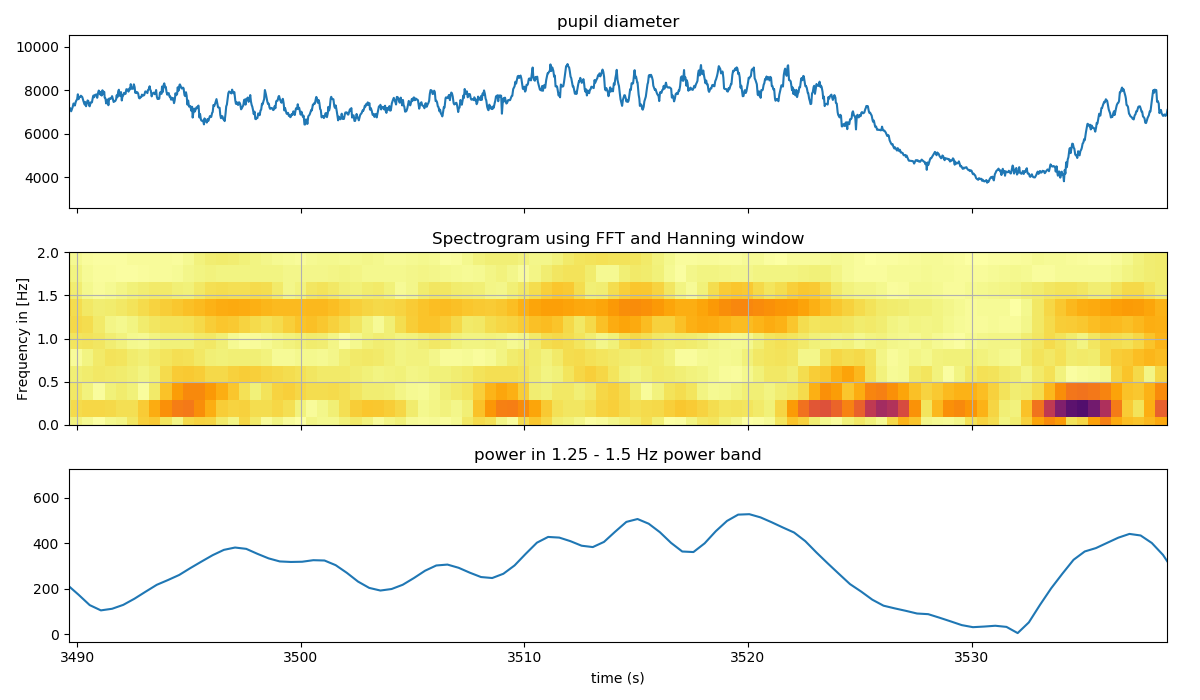

In [135]:
delta_f  =  f[1] - f[0]
delta_t_ = t_[1] - t_[0]
t2  = t_ + new_t[0] - delta_t_

fig,ax=plt.subplots(3,1,figsize=(12,7),sharex=True)
ax[0].plot(new_t,y_interp)
im = ax[1].pcolormesh(t2, f - delta_f/2, np.sqrt(2*Sxx), cmap = "inferno_r")#, alpha = 0.5)
ax[1].grid(True)
ax[1].set_ylabel("Frequency in [Hz]")
ax[1].set_ylim(0, 2)
ax[1].set_xlim(np.min(t2),np.max(t2))
ax[1].set_title("Spectrogram using FFT and Hanning window")

power_in_image_f = np.sqrt(2*Sxx)[7,:]

ax[2].plot(t_,power_in_image_f)

ax[2].set_title('power in 1.25 - 1.5 Hz power band')
ax[0].set_title('pupil diameter')

ax[0].set_xlim(3200,3800)
ax[2].set_xlabel('time (s)')
fig.tight_layout()

In [125]:
def get_area(t):
    return df.iloc[df.index.get_loc(t,method='nearest',tolerance=0.2)]['blink_corrected_area']

df_power = pd.DataFrame()
df_power['time'] = t_
df_power['power'] = power_in_image_f
df_power['amplitude'] = df_power['time'].map(lambda t:get_area(t))

<IPython.core.display.Javascript object>


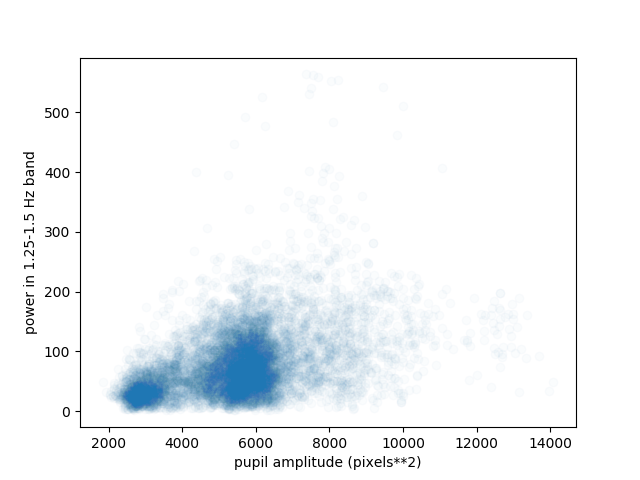

Text(0, 0.5, 'power in 1.25-1.5 Hz band')

In [127]:
fig,ax=plt.subplots()
ax.scatter(df_power['amplitude'],df_power['power'],alpha=0.2)
ax.set_xlabel('pupil amplitude (pixels**2)')
ax.set_ylabel('power in 1.25-1.5 Hz band')